In [8]:
# # Downloading the dataset - Run When using GitHub, as the download path is based on GitHUb CodeSpaces
# !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet -P /workspaces/mlops-learning/01-intro/data
# !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet -P /workspaces/mlops-learning/01-intro/data


# # Download 2021 data
# !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet -P /workspaces/mlops-learning/01-intro/data
# !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-02.parquet -P /workspaces/mlops-learning/01-intro/data

# When Running on Other Platform
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet -P ../01-intro/data
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet -P ../01-intro/data


# Download 2021 data
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet -P ../01-intro/data
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-02.parquet -P ../01-intro/data

--2024-08-30 08:07:35--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 13.226.36.130, 13.226.36.73, 13.226.36.218, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|13.226.36.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49961641 (48M) [binary/octet-stream]
Saving to: ‘../01-intro/data/yellow_tripdata_2024-01.parquet’

yellow_tripdata_202 100%[===================>]  47.65M  --.-KB/s    in 0.1s    

2024-08-30 08:07:35 (346 MB/s) - ‘../01-intro/data/yellow_tripdata_2024-01.parquet’ saved [49961641/49961641]



--2024-08-30 08:07:35--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 13.226.36.130, 13.226.36.73, 13.226.36.196, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|13.226.36.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50349284 (48M) [binary/octet-stream]
Saving to: ‘../01-intro/data/yellow_tripdata_2024-02.parquet’

yellow_tripdata_202 100%[===================>]  48.02M  --.-KB/s    in 0.1s    

2024-08-30 08:07:35 (410 MB/s) - ‘../01-intro/data/yellow_tripdata_2024-02.parquet’ saved [50349284/50349284]

--2024-08-30 08:07:35--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 13.226.36.73, 13.226.36.130, 13.226.36.218, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|13.226.36.73

To check the indepth version of Training and Prediction, check 01-intro folder

In [1]:
# importing all the necesasry libraries

import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import root_mean_squared_error


from sklearn.model_selection import cross_val_score, KFold

We start by Setting the Tracking URI

In [2]:
import mlflow

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# run only one from the below and comment the other

# Create a new MLflow Experiment - Inside an experiment, there will be Runs
# mlflow.set_experiment("taxi-prediction-xgboost-hyperopt")

# Creating a new one for AutoLog, so can see the with and without AutoLog
mlflow.set_experiment("taxi-prediction-xgboost-hyperopt-with-autolog")

<Experiment: artifact_location='mlflow-artifacts:/114282133553756653', creation_time=1725019412855, experiment_id='114282133553756653', last_update_time=1725019412855, lifecycle_stage='active', name='taxi-prediction-xgboost-hyperopt-with-autolog', tags={}>

In [3]:
# a function to read the data, preprocess it and return it
def read_and_preprocess(filename):
    data = pd.read_parquet(filename)
    
    # create the target variable
    data['ride_duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'] 
    data['ride_duration'] = data['ride_duration'].apply(lambda x: x.total_seconds()/60) 

    # take only the data below 1 hour
    data = data[(data['ride_duration'] >= 1) & (data['ride_duration'] <= 60)]

    # # sample the data to 70k rows
    # if len(data) > 70000:
    #     sampled_data = data.iloc[:70000,:].copy()
    # else:
    #     sampled_data = data.copy()
    sampled_data = data.copy()
    
    # chosing categorical
    categorical = ['PULocationID', 'DOLocationID']

    # convert these numerical categorical features to string categorical features
    sampled_data[categorical] = sampled_data[categorical].astype(str)


    return sampled_data

In [4]:
# When using GitHub CodeSpaces - Path is Set according to that
# df_train = read_and_preprocess('/workspaces/mlops-learning/01-intro/data/yellow_tripdata_2021-01.parquet')
# df_valid = read_and_preprocess('/workspaces/mlops-learning/01-intro/data/yellow_tripdata_2021-02.parquet')

# when not using GitHub CodeSpaces
df_train = read_and_preprocess('../01-intro/data/yellow_tripdata_2021-01.parquet')
df_valid = read_and_preprocess('../01-intro/data/yellow_tripdata_2021-02.parquet')

In [5]:
# chosing categorical and numerical features
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# to use the DictVectorizer, we need to convert the dataframe to dict
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_valid[categorical + numerical].to_dict(orient='records')


dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_valid = dv.fit_transform(val_dicts)

# storing our target variable
target = 'ride_duration'
y_train = df_train[target].values
y_val = df_valid[target].values

Using XGBoost

In [6]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [7]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_valid, label=y_val)

In [9]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

The below code does not use AutoLog. For AutoLog, skip this step

In [29]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

# so the objective will be called 10 times and for each time, a run will be registered in the MLFlow
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/root/mlops-learning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.76296                           
[1]	validation-rmse:8.28224                           
[2]	validation-rmse:7.84964                           
[3]	validation-rmse:7.46061                           
[4]	validation-rmse:7.11444                           
[5]	validation-rmse:6.80408                           
[6]	validation-rmse:6.52773                           
[7]	validation-rmse:6.28252                           
[8]	validation-rmse:6.06369                           
[9]	validation-rmse:5.86982                           
[10]	validation-rmse:5.70158                          
[11]	validation-rmse:5.55365                          
[12]	validation-rmse:5.42534                          
[13]	validation-rmse:5.31378                          
[14]	validation-rmse:5.21564                          
[15]	validation-rmse:5.13104                          
[16]	validation-rmse:5.05841                          
[17]	validation-rmse:4.99481                          
[18]	valid

2024/08/30 10:38:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-whale-158 at: http://127.0.0.1:5000/#/experiments/107471247143277881/runs/0a741829cadb4384993cb10a25f4e486.

2024/08/30 10:38:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/107471247143277881.



 10%|█         | 1/10 [04:54<44:11, 294.65s/trial, best loss: 4.67849580384672]

/root/mlops-learning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:38:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.67660                                                    
[1]	validation-rmse:5.43606                                                    
[2]	validation-rmse:4.91277                                                    
[3]	validation-rmse:4.70318                                                    
[4]	validation-rmse:4.61194                                                    
[5]	validation-rmse:4.57404                                                    
[6]	validation-rmse:4.55323                                                    
[7]	validation-rmse:4.53264                                                    
[8]	validation-rmse:4.52164                                                    
[9]	validation-rmse:4.51520                                                    
[10]	validation-rmse:4.51177                                                   
[11]	validation-rmse:4.51555                                                   
[12]	validation-rmse:4.51695            

2024/08/30 10:38:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-cat-874 at: http://127.0.0.1:5000/#/experiments/107471247143277881/runs/c43d89bd9fb14bd5857e7c0f626f03e7.

2024/08/30 10:38:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/107471247143277881.



 20%|██        | 2/10 [05:10<17:27, 130.89s/trial, best loss: 4.504647348518104]

/root/mlops-learning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:38:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4.85477                                                     
[1]	validation-rmse:4.64241                                                     
[2]	validation-rmse:4.68379                                                     
[3]	validation-rmse:4.69738                                                     
[4]	validation-rmse:4.73046                                                     
[5]	validation-rmse:4.75036                                                     
[6]	validation-rmse:4.76795                                                     
[7]	validation-rmse:4.78693                                                     
[8]	validation-rmse:4.79663                                                     
[9]	validation-rmse:4.81546                                                     
[10]	validation-rmse:4.83213                                                    
[11]	validation-rmse:4.85837                                                    
 20%|██        | 2/10 [05:24

2024/08/30 10:39:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-bat-114 at: http://127.0.0.1:5000/#/experiments/107471247143277881/runs/fe6d20b2a1994184b313f473bca089a1.

2024/08/30 10:39:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/107471247143277881.



 30%|███       | 3/10 [05:28<09:15, 79.29s/trial, best loss: 4.504647348518104] 

/root/mlops-learning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:39:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.36936                                                    
[1]	validation-rmse:4.68225                                                    
[2]	validation-rmse:4.58157                                                    
[3]	validation-rmse:4.55547                                                    
[4]	validation-rmse:4.54169                                                    
[5]	validation-rmse:4.54798                                                    
[6]	validation-rmse:4.54524                                                    
[7]	validation-rmse:4.54581                                                    
[8]	validation-rmse:4.55304                                                    
[9]	validation-rmse:4.55216                                                    
[10]	validation-rmse:4.54620                                                   
[11]	validation-rmse:4.54877                                                   
[12]	validation-rmse:4.55371            

2024/08/30 10:39:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-shoat-743 at: http://127.0.0.1:5000/#/experiments/107471247143277881/runs/63ce0c44109d4f0895fb6e46cdc1c3c2.

2024/08/30 10:39:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/107471247143277881.



 40%|████      | 4/10 [05:40<05:16, 52.79s/trial, best loss: 4.504647348518104]

/root/mlops-learning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:39:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.04237                                                    
[1]	validation-rmse:4.95930                                                    
[2]	validation-rmse:4.71115                                                    
[3]	validation-rmse:4.66686                                                    
[4]	validation-rmse:4.66125                                                    
[5]	validation-rmse:4.68010                                                    
[6]	validation-rmse:4.68879                                                    
[7]	validation-rmse:4.72415                                                    
[8]	validation-rmse:4.73713                                                    
[9]	validation-rmse:4.74797                                                    
[10]	validation-rmse:4.76058                                                   
[11]	validation-rmse:4.76900                                                   
[12]	validation-rmse:4.79090            

2024/08/30 10:39:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run mysterious-dove-102 at: http://127.0.0.1:5000/#/experiments/107471247143277881/runs/14bef8fcc76e41c59080753766801b2a.

2024/08/30 10:39:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/107471247143277881.



 50%|█████     | 5/10 [06:15<03:51, 46.29s/trial, best loss: 4.504647348518104]

/root/mlops-learning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:39:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.37029                                                    
[1]	validation-rmse:7.60576                                                    
[2]	validation-rmse:6.98080                                                    
[3]	validation-rmse:6.48170                                                    
[4]	validation-rmse:6.07250                                                    
[5]	validation-rmse:5.75031                                                    
[6]	validation-rmse:5.49443                                                    
[7]	validation-rmse:5.29412                                                    
[8]	validation-rmse:5.14117                                                    
[9]	validation-rmse:5.02089                                                    
[10]	validation-rmse:4.92637                                                   
[11]	validation-rmse:4.85416                                                   
[12]	validation-rmse:4.79942            

2024/08/30 10:40:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run orderly-lynx-676 at: http://127.0.0.1:5000/#/experiments/107471247143277881/runs/7e1fa85c956449e8a3e5553359e1e89c.

2024/08/30 10:40:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/107471247143277881.



 60%|██████    | 6/10 [06:53<02:53, 43.40s/trial, best loss: 4.504647348518104]

/root/mlops-learning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:40:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.95202                                                    
[1]	validation-rmse:6.94346                                                    
[2]	validation-rmse:6.19513                                                    
[3]	validation-rmse:5.66004                                                    
[4]	validation-rmse:5.28520                                                    
[5]	validation-rmse:5.03459                                                    
[6]	validation-rmse:4.86222                                                    
[7]	validation-rmse:4.74676                                                    
[8]	validation-rmse:4.67753                                                    
[9]	validation-rmse:4.62966                                                    
[10]	validation-rmse:4.59988                                                   
[11]	validation-rmse:4.58104                                                   
[12]	validation-rmse:4.57153            

2024/08/30 10:41:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-pig-204 at: http://127.0.0.1:5000/#/experiments/107471247143277881/runs/e2cecf29cb6644e0af03dd49bcf9b31d.

2024/08/30 10:41:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/107471247143277881.



 70%|███████   | 7/10 [08:09<02:41, 53.95s/trial, best loss: 4.504647348518104]

/root/mlops-learning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:41:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.92604                                                    
[1]	validation-rmse:8.58084                                                    
[2]	validation-rmse:8.25866                                                    
[3]	validation-rmse:7.95789                                                    
[4]	validation-rmse:7.67825                                                    
[5]	validation-rmse:7.41811                                                    
[6]	validation-rmse:7.17633                                                    
[7]	validation-rmse:6.95198                                                    
[8]	validation-rmse:6.74437                                                    
[9]	validation-rmse:6.55206                                                    
[10]	validation-rmse:6.37482                                                   
[11]	validation-rmse:6.21138                                                   
[12]	validation-rmse:6.06082            

2024/08/30 10:47:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run casual-owl-71 at: http://127.0.0.1:5000/#/experiments/107471247143277881/runs/ff459969e2c547229915eaf13c4380bc.

2024/08/30 10:47:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/107471247143277881.



 80%|████████  | 8/10 [13:30<04:38, 139.15s/trial, best loss: 4.504647348518104]

/root/mlops-learning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:47:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.28970                                                     
[1]	validation-rmse:7.46737                                                     
[2]	validation-rmse:6.80277                                                     
[3]	validation-rmse:6.27201                                                     
[4]	validation-rmse:5.85358                                                     
[5]	validation-rmse:5.52611                                                     
[6]	validation-rmse:5.27233                                                     
[7]	validation-rmse:5.08073                                                     
[8]	validation-rmse:4.93512                                                     
[9]	validation-rmse:4.82608                                                     
[10]	validation-rmse:4.74464                                                    
[11]	validation-rmse:4.68325                                                    
[12]	validation-rmse:4.63980

2024/08/30 10:49:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-ray-925 at: http://127.0.0.1:5000/#/experiments/107471247143277881/runs/222d660ecce24adfa41442b4e2f395b9.

2024/08/30 10:49:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/107471247143277881.



 90%|█████████ | 9/10 [15:31<02:13, 133.42s/trial, best loss: 4.504647348518104]

/root/mlops-learning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:49:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.49508                                                     
[1]	validation-rmse:5.27101                                                     
[2]	validation-rmse:4.81807                                                     
[3]	validation-rmse:4.66455                                                     
[4]	validation-rmse:4.60846                                                     
[5]	validation-rmse:4.59279                                                     
[6]	validation-rmse:4.57714                                                     
[7]	validation-rmse:4.56750                                                     
[8]	validation-rmse:4.56758                                                     
[9]	validation-rmse:4.57087                                                     
[10]	validation-rmse:4.57360                                                    
[11]	validation-rmse:4.57406                                                    
[12]	validation-rmse:4.57330

2024/08/30 10:49:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-bug-95 at: http://127.0.0.1:5000/#/experiments/107471247143277881/runs/f609759083824907a1388169c733fbd8.

2024/08/30 10:49:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/107471247143277881.



100%|██████████| 10/10 [15:48<00:00, 94.83s/trial, best loss: 4.504647348518104]


We can also use the Built-in Auto Logging Provided by MLFlow for different models

Here, we are testing for a single example. 

In [8]:
# these parameters are taken after running the above cell and
# checking which parameters got the best rmse
params = {
    'max_depth': 36,
    'learning_rate': 0.4,
    'reg_alpha': 0.015,
    'reg_lambda': 0.0053,
    'min_child_weight': 15.88,
    'seed': 42
}

# we provide the autolog here, just before the run function which gets executed in objective function
mlflow.xgboost.autolog() 

# so the objective will be called 10 times and for each time, a run will be registered in the MLFlow
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )


2024/08/30 12:13:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/08/30 12:13:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f8b84fbc41164e0eacc741978372fbc4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


: 

In [10]:
# chosing categorical and numerical features
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# to use the DictVectorizer, we need to convert the dataframe to dict
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_valid[categorical + numerical].to_dict(orient='records')


dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_valid = dv.fit_transform(val_dicts)

# storing our target variable
target = 'ride_duration'
y_train = df_train[target].values
y_val = df_valid[target].values

In [11]:
# train a LinearRegression Model
lr = LinearRegression()

lr.fit(X_train, y_train)

# make predictions on test_data
y_pred = lr.predict(X_valid)

# calculate the metrics
root_mean_squared_error(y_val, y_pred) # squared set to False implies we are using RMSE instead MSE

7.683747664707015

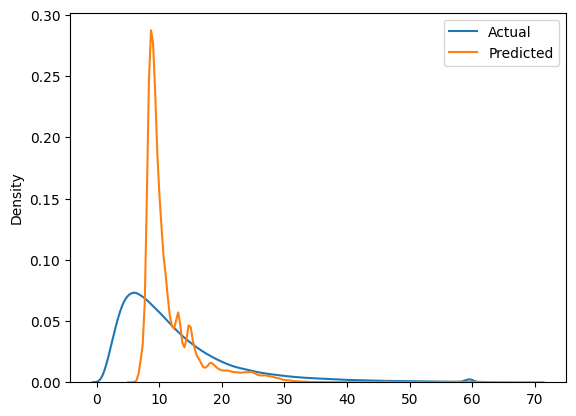

In [12]:
# sns.displot(y_train, kde=True, stat='density',kde_kws=dict(cut=3), label='Actual')
# sns.displot(y_pred, kde=True, stat='density',kde_kws=dict(cut=3), label='Predicted') 

# sns.distplot(y_train, kde=True, label='Actual')
# sns.distplot(y_pred, kde=True, label='Predicted') 

sns.kdeplot(y_val,label='Actual')
sns.kdeplot(y_pred,label='Predicted') 

plt.legend()


Let's say, we want to monitor the performance of Lasso. We can do that with MLflow

In [13]:
# train a Lasso Model
with mlflow.start_run():
    # adding tags, so we can use them to filter
    mlflow.set_tag("model",'LASSO')

    # adding data sources for train and validation (this is basic and there might be a better way to do it)
    paths = {'train-data-path':'01-intro/data/yellow_tripdata_2021-01.parquet',
             'val-data-path':'01-intro/data/yellow_tripdata_2021-02.parquet'}

    # log_params() is for logging multiple params
    mlflow.log_params(params=paths)

    # log_param() is logging single parameter
    alpha = 0.1

    mlflow.log_param("alpha",alpha)

    # training the model
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    # make predictions on test_data
    y_pred = lr.predict(X_valid)

    # calculate the metrics
    rmse = root_mean_squared_error(y_val, y_pred) # squared set to False implies we are using RMSE instead MSE

    # logging the metrics
    mlflow.log_metric("rmse",rmse) # use log_metrics() to log multiple metrics, it takes a dict of metrics and their values

2024/08/30 08:08:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run amazing-deer-716 at: http://127.0.0.1:5000/#/experiments/607365059119017646/runs/2479dd72165b4b809766591d690f3023.
2024/08/30 08:08:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607365059119017646.


### K-Fold Cross Valiation

In [24]:
# Convert the dataset to dictionaries
train_dicts = train_data.to_dict(orient='records')

# Vectorize the data
dv = DictVectorizer()
X = dv.fit_transform(train_dicts)
y = sampled_data['ride_duration'].values

# Initialize the Linear Regression model
lr = LinearRegression()

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_rmse = np.sqrt(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error'))

print(f'Cross-Validation RMSE: {cv_rmse}')
print(f'Average Cross-Validation RMSE: {cv_rmse.mean()}')

Cross-Validation RMSE: [5.87214604 5.94142789 5.96554232 5.80563044 5.80900893]
Average Cross-Validation RMSE: 5.87875112379174


`scoring='neg_mean_squared_error'`: This tells cross_val_score to evaluate the model using the Negative Mean Squared Error (MSE) as the scoring metric. The reason for using "negative" MSE is that cross_val_score by default assumes higher scores are better, so negative values allow it to maintain consistency (since MSE is a loss function, lower is better).

`-cross_val_score(...):`

The scores returned by cross_val_score are negative because of the `neg_mean_squared_error` scoring. By negating them (multiplying by -1), you get the actual Mean Squared Error (MSE) values for each fold. If it's negative we cannot take the square root of it

MSE is the average of the squared differences between the predicted and actual values. RMSE is the square root of the MSE, which is more interpretable because it’s in the same units as the target variable (ride_duration in this case).


In [26]:
# Perform cross-validation - Without Scoring Variable
# if scoring is not mentioned, the default score func of estimator will be used
# the default scorer for LinearReg is R Square i.e. (1 - u/v), where
# "u" is he residual sum of squares ((y_true - y_pred)** 2).sum() and is the total sum of squares ((y_true - y_true.mean()) ** 2).sum()
# and the best possible score is 1.0 and worst is 0
cv_rmse = np.sqrt(cross_val_score(lr, X, y, cv=kf))

print(f'Cross-Validation RMSE: {cv_rmse}')
print(f'Average Cross-Validation RMSE: {cv_rmse.mean()}')

Cross-Validation RMSE: [0.82801636 0.81976742 0.82515868 0.82878804 0.83299871]
Average Cross-Validation RMSE: 0.826945840395376
